#### Load all the required libraries

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math
from pathlib import Path
os.environ["CUDA_VISIBLE_DEVICES"]="3"
%matplotlib inline

#### Define helper function to plot images in grids

In [2]:
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

#### Define the datagenerator

In [3]:
#IMGNET_DIR = Path('/Users/evpc/Documents/kaggle/datasets/tiny-imagenet-200')
IMGNET_DIR = Path('/raid/USERDATA/fedore9x/datasets/tiny-imagenet-200')
TRAIN_DIR = IMGNET_DIR/'train'
VAL_DIR = IMGNET_DIR/'val'

In [22]:
BATCH_SIZE=512
IMG_SIZE=(64, 64)
#datagen_args = dict(rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#                   rescale=1./255)
#datagen = ImageDataGenerator(**datagen_args)
#
#train_gen = datagen.flow_from_directory(TRAIN_DIR,target_size=IMG_SIZE,
#                                            batch_size=BATCH_SIZE,interpolation="lanczos",shuffle=True)
#val_gen = datagen.flow_from_directory(VAL_DIR,target_size=IMG_SIZE,
#                                            batch_size=BATCH_SIZE,interpolation="lanczos",shuffle=True)


datagen_args = dict(rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    rescale=1./255,
                    validation_split=0.1)
datagen = ImageDataGenerator(**datagen_args)
train_gen = datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE,
                                            batch_size=BATCH_SIZE,interpolation="lanczos",shuffle=True,subset='training')
val_gen = datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE,
                                            batch_size=BATCH_SIZE,interpolation="lanczos",shuffle=True,subset='validation')

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [23]:
def print_datagen_info(datagen):
    print('Number of samples: ',datagen.samples)
    print('Number of classes: ',len(datagen.class_indices))
    print('Number of samples per class:', int(datagen.samples/len(datagen.class_indices)))

print('\t\tTraining dataset:')
print_datagen_info(train_gen)
print('\t\tVal dataset:')
print_datagen_info(val_gen)

		Training dataset:
Number of samples:  90000
Number of classes:  200
Number of samples per class: 450
		Val dataset:
Number of samples:  10000
Number of classes:  200
Number of samples per class: 50


In [24]:
import pandas as pd
words = pd.read_csv(IMGNET_DIR/'words.txt', sep='\t', names=['filename', 'words'])
words = words.set_index('filename')
words

,words
filename,
n00001740,entity
n00001930,physical entity
n00002137,"abstraction, abstract entity"
n00002452,thing
n00002684,"object, physical object"
...,...
n15299225,study hall
n15299367,"Transfiguration, Transfiguration Day, August 6"
n15299585,usance


In [25]:
words.loc['n00001740']

words    entity
Name: n00001740, dtype: object

In [26]:
for e in list(train_gen.class_indices.keys())[:10]:
    print(e, words.loc[e, 'words'])

n01443537 goldfish, Carassius auratus
n01629819 European fire salamander, Salamandra salamandra
n01641577 bullfrog, Rana catesbeiana
n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
n01698640 American alligator, Alligator mississipiensis
n01742172 boa constrictor, Constrictor constrictor
n01768244 trilobite
n01770393 scorpion
n01774384 black widow, Latrodectus mactans
n01774750 tarantula


In [27]:
class_mapping = {k:words.loc[k, 'words'] for k, v in train_gen.class_indices.items()}
class_mapping = {v:words.loc[k, 'words'] for k, v in train_gen.class_indices.items()}

In [28]:
x,y = next(train_gen)
print('x: ',type(x))
print('y: ',type(y))
print('x: ',x.shape)
print('y: ',y.shape)

x:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>
x:  (512, 64, 64, 3)
y:  (512, 200)


In [29]:
#Get class int vale from one hot encoded labels
y_int = np.argmax(y,axis=-1)

In [30]:
y_int

array([112,  90,  37, 151,   3, 140,  64, 179, 164,   6, 122, 195,  96,
        59, 165,   3, 190,  15,  61,  81, 196, 107,  77, 170, 198,  37,
        82, 119, 137,  70,  34,  36, 107,  65,  62,  21, 116, 190,  92,
        83, 145, 139, 197,  29, 161, 160,  49,  66, 125,  72, 170, 168,
        25, 157, 183,  57, 177,  94,  78, 195,  57, 123,  95, 142, 145,
       122,   3, 105,   5, 155, 120, 173, 155, 146,  65,  14,   6,  74,
        73,  68, 198,  68,  84, 132,  37, 101, 111, 100, 180,  91, 193,
       118,  37, 153,  72, 111, 122,  76,  55, 111,  42, 138, 180, 195,
        67,  44, 115,  55, 170, 172,  70,  38, 167, 191,  51,   0,  72,
        18, 177, 119,  18,  28, 117,   1,  58,   4, 131, 191,  50,  97,
        64, 167,  17,  35,  13, 109, 116,  49,  75, 126,  95,  35,  63,
       177, 150,  90, 175, 155,  20,  99, 104,  75, 154, 170,  78,   0,
       133,  59, 111,  41,  52,  52,  18,   9,  66, 119, 118,  93,  79,
        28, 158, 165,  57,  68, 129, 136,  55,  56,   5, 190, 18

#### Visualize the batch of images

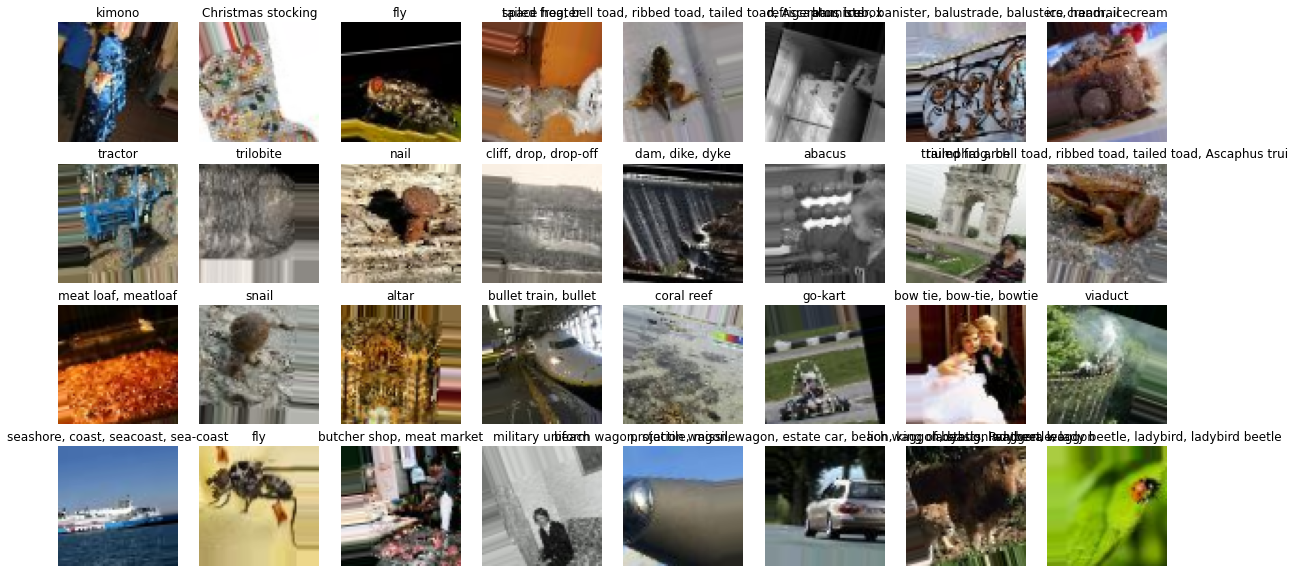

In [31]:
show_grid(x,4,8,label_list=y_int,show_labels=True,figsize=(20,10),savename=None)

#### Visualizing batch images w.r.t. the original images

#### Train using Image DataGenerator

In [32]:
import lib.models as mymodels
from tensorflow.keras.optimizers import Adam

N_CLASSES = len(train_gen.class_indices.values())
mymodel = mymodels.vers1_classificator(N_CLASSES, IMG_SIZE[0], IMG_SIZE[1])
mymodel.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy', 'top_k_categorical_accuracy'])
mymodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 64, 64, 32)   896         ['main_input[0][0]']             
                                                                                                  
 batch_normalization_18 (BatchN  (None, 64, 64, 32)  128         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_18 (ReLU)                (None, 64, 64, 32)   0           ['batch_normalization_18[0]

/raid/USERDATA/fedore9x/venv/tf2/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
epochs = 50

log_fname='log.csv'
history_log_callback = tf.keras.callbacks.CSVLogger(log_fname, separator=",", append=True)

checkpnt_fpath = Path.cwd()/'checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpnt_fpath, save_freq='epoch',
                                                         save_weights_only=True, save_best_only=False,
                                                        )

history = mymodel.fit(train_gen, validation_data=val_gen,
                        steps_per_epoch= math.ceil(train_gen.samples//BATCH_SIZE),
                        callbacks = [history_log_callback, checkpoint_callback],
                        epochs=epochs, verbose=1)

Epoch 1/50
175/175 [==============================] - 88s 500ms/step - loss: 1.3509 - accuracy: 0.6403 - top_k_categorical_accuracy: 0.8755 - val_loss: 2.7007 - val_accuracy: 0.3990 - val_top_k_categorical_accuracy: 0.6651
Epoch 2/50
175/175 [==============================] - 87s 499ms/step - loss: 1.2543 - accuracy: 0.6625 - top_k_categorical_accuracy: 0.8895 - val_loss: 2.8567 - val_accuracy: 0.3843 - val_top_k_categorical_accuracy: 0.6520
Epoch 3/50
175/175 [==============================] - 86s 489ms/step - loss: 1.1498 - accuracy: 0.6846 - top_k_categorical_accuracy: 0.9058 - val_loss: 2.8279 - val_accuracy: 0.3933 - val_top_k_categorical_accuracy: 0.6584
Epoch 4/50
175/175 [==============================] - 86s 492ms/step - loss: 1.0597 - accuracy: 0.7074 - top_k_categorical_accuracy: 0.9176 - val_loss: 2.8209 - val_accuracy: 0.4092 - val_top_k_categorical_accuracy: 0.6693
Epoch 5/50
175/175 [==============================] - 87s 498ms/step - loss: 0.9727 - accuracy: 0.7285 - top

#### Using DataGenerator to predict on test set

In [ ]:
#This ensures you start from first batch. 
#And the datagen shuffle is set to False. 
#This will allow you to correspond the predictions with the generator filenames.
dgen_no_shuffle.reset() 
y = model.predict_generator(dgen_no_shuffle,steps= math.ceil(dgen_no_shuffle.samples//batch_size))

In [ ]:
Using validation split

In [3]:
batch_size=32
datagen_args = dict(rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    rescale=1./255,
                    validation_split=0.2)
datagen = ImageDataGenerator(**datagen_args)
train_generator = datagen.flow_from_directory('./Dataset/dtd/images',target_size=(128,128),
                                            batch_size=batch_size,interpolation="lanczos",shuffle=True,subset='training')
validation_generator = datagen.flow_from_directory('./Dataset/dtd/images',target_size=(128,128),
                                            batch_size=batch_size,interpolation="lanczos",shuffle=True,subset='validation')

Found 4512 images belonging to 47 classes.
Found 1128 images belonging to 47 classes.
